# Named Entity Recognition (NER) from News Articles

In [38]:
import os
import re
from collections import Counter
from pathlib import Path
import random

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from spacy import displacy
from spacy.language import Language
from spacy.tokens import Span

from seqeval.metrics import classification_report, f1_score

In [2]:
# Creating folders that we are going to use
from pathlib import Path

DATA_DIR = Path("data")
PLOTS_DIR = Path("plots")

PLOTS_DIR.mkdir(parents = True, exist_ok = True)

print("Data Folder : ", DATA_DIR.resolve())
print("Plots will be saved to : ", PLOTS_DIR.resolve())

Data Folder :  C:\Elevvo_NLP_Internship\4_Named_Entity_Recognition_from_News_Articles\data
Plots will be saved to :  C:\Elevvo_NLP_Internship\4_Named_Entity_Recognition_from_News_Articles\plots


In [32]:
SEED = 42
random.seed(SEED)

## Loading the CoNLL-2003 (English) dataset (<a href="https://www.kaggle.com/datasets/alaakhaled/conll003-englishversion?select=metadata">link</a>)

In [3]:
train_path = DATA_DIR / "train.txt"
valid_path = DATA_DIR / "valid.txt"
test_path  = DATA_DIR / "test.txt"

In [4]:
# Function to read CoNLL files
def read_conll(file_path):
    sentences, tags = [], []
    cur_tokens, cur_tags = [], []

    with open(file_path, "r", encoding="utf8") as f:
        for raw_line in f:
            line = raw_line.strip()
            
            # Blank line is end of sentence
            if not line:
                if cur_tokens: # if we actually collected tokens
                    sentences.append(cur_tokens) # save the sentence
                    tags.append(cur_tags) # save tags
                    cur_tokens, cur_tags = [], [] # reset for next sentence
                continue

            # DOCSTRAT lines - we will skip this entirly as they are not real tokens
            if line.startswith("-DOCSTART-"):
                # also end of any sentence in progess
                if cur_tokens: # if we actually collected tokens
                    sentences.append(cur_tokens) # save the sentence
                    tags.append(cur_tags) # save tags
                    cur_tokens, cur_tags = [], [] # reset for next sentence
                continue

            # Normal token line
            # CoNLL columns are typically - token, POS, chunk, NER (we only need token and NER)
            parts = line.split()

            # check some lines can be malformed; skip if too short
            if len(parts) < 4:
                print(f"Skipping malformed line in {file_path!r}: {line!r}")
                continue

            token = parts[0] # 1st column is token
            ner_tag = parts[-1] # last column is ner tag

            cur_tokens.append(token)
            cur_tags.append(ner_tag)

        # Catching any sentence that wasn;t closed by a blank line at EOF
        if cur_tokens: # if we actually collected tokens
            sentences.append(cur_tokens) # save the sentence
            tags.append(cur_tags) # save tags
        return sentences, tags

In [5]:
# Load all datasets
train_sents, train_tags = read_conll(train_path)
val_sents,   val_tags   = read_conll(valid_path)
test_sents,  test_tags  = read_conll(test_path)

In [6]:
# Displaying sizes
print("Train sentences:", len(train_sents))
print("Valid sentences:", len(val_sents))
print("Test sentences :", len(test_sents))

Train sentences: 14041
Valid sentences: 3250
Test sentences : 3453


In [7]:
# Each sentence must have the same number of tokens and tags
def count_mismatches(sents, tags):
    return sum(1 for s, t in zip(sents, tags) if len(s) != len(t))

print("Train mismatches:", count_mismatches(train_sents, train_tags))
print("Valid mismatches:", count_mismatches(val_sents, val_tags))
print("Test  mismatches:", count_mismatches(test_sents,  test_tags))

Train mismatches: 0
Valid mismatches: 0
Test  mismatches: 0


In [8]:
# Displaying one sentence and its tags
idx = 0  
print("Sample tokens:", train_sents[idx][:20])
print("Sample tags  :", train_tags[idx][:20])

Sample tokens: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
Sample tags  : ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


## Token to char alignment and prediction conversion

In [9]:
def token_char_offsets(tokens):
    text = " ".join(tokens)
    offsets = []
    i = 0  # search start position
    for tok in tokens:
        start = text.find(tok, i)
        end   = start + len(tok)
        offsets.append((start, end))
        i = end  # move search window forward
    return text, offsets

In [10]:
def spacy_doc_to_bio(doc, tokens):
    _, offsets = token_char_offsets(tokens)
    tags = ["O"] * len(tokens)

    for ent in doc.ents:
        first = True
        for i, (a, b) in enumerate(offsets):
            # token is fully inside ent span
            if a >= ent.start_char and b <= ent.end_char:
                tags[i] = ("B-" if first else "I-") + ent.label_
                first = False
    return tags

In [11]:
def predict_bio(nlp: Language, sentences):
    preds = []
    # Process sentence by sentence (small batches keep it simple)
    for tokens in sentences:
        text = " ".join(tokens)
        doc  = nlp(text)
        pred_tags = spacy_doc_to_bio(doc, tokens)
        preds.append(pred_tags)
    return preds

In [12]:
def evaluate_model(nlp_name, sentences, gold_tags):
    print(f"\nLoading model : {nlp_name}")
    nlp = spacy.load(nlp_name)

    print("Predicting....")
    pred_tags = predict_bio(nlp, sentences)

    print("\nSeqeval classification report (per entity type) :")
    print(classification_report(gold_tags, pred_tags, digits=3))

    f1 = f1_score(gold_tags, pred_tags)
    print(f"Overall micro F1 : {f1:.3f}")
    return pred_tags, f1

In [13]:
def extract_f1_per_label(report_text):
    f1_dict = {}
    for line in report_text.splitlines():
        parts = line.strip().split()
        # We are expecting label, precision, recall, f1, support
        if len(parts) == 5 and parts[0].isalpha():
            label, p, r, f1, sup = parts
            try:
                f1_val = float(f1)
                f1_dict[label] = f1_val
            except:
                pass
    return f1_dict

In [14]:
def plot_f1_bars(
    f1_dict: dict,
    title: str,
    save_path: Path,
    filter_labels=("PER","ORG","LOC","MISC"),
    sort_desc=True,
    annotate=True,
    figsize=(8,5),
):
    
    # filter to the labels we care about (PER/ORG/LOC/MISC for CoNLL-2003)
    if filter_labels:
        labels = [lab for lab in filter_labels if lab in f1_dict]
    else:
        labels = list(f1_dict.keys())

    values = [float(f1_dict[l]) for l in labels]

    # sort by value
    if sort_desc and len(labels) > 1:
        pairs = sorted(zip(labels, values), key=lambda x: x[1], reverse=True)
        labels, values = zip(*pairs)

    # plot
    plt.figure(figsize=figsize)
    plt.bar(labels, values)
    plt.ylim(0, 1.0)
    plt.title(title)
    plt.xlabel("Entity type")
    plt.ylabel("F1 score")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.xticks(rotation=20)

    # annotate bar tops
    if annotate:
        for x, v in enumerate(values):
            plt.text(x, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=10)

    plt.tight_layout()
    plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()
    print(f"Saved plot to : {save_path}")

## Baseline 1 : en_core_web_sm on test set

In [15]:
# Evaluating the small (CPU-friendly) model
pred_sm, f1_sm = evaluate_model("en_core_web_sm", test_sents, test_tags)


Loading model : en_core_web_sm
Predicting....

Seqeval classification report (per entity type) :


c:\Elevvo_NLP_Internship\venv\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Elevvo_NLP_Internship\venv\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    CARDINAL      0.000     0.000     0.000         0
        DATE      0.000     0.000     0.000         0
       EVENT      0.000     0.000     0.000         0
         FAC      0.000     0.000     0.000         0
         GPE      0.000     0.000     0.000         0
    LANGUAGE      0.000     0.000     0.000         0
         LAW      0.000     0.000     0.000         0
         LOC      0.494     0.023     0.044      1668
        MISC      0.000     0.000     0.000       702
       MONEY      0.000     0.000     0.000         0
        NORP      0.000     0.000     0.000         0
     ORDINAL      0.000     0.000     0.000         0
         ORG      0.445     0.304     0.361      1661
         PER      0.000     0.000     0.000      1617
     PERCENT      0.000     0.000     0.000         0
      PERSON      0.000     0.000     0.000         0
     PRODUCT      0.000     0.000     0.000         0
    QUANTITY      0.000    

In [16]:
# Making and saving a per-entity F1 bar chart for the small model.
report_text_sm = classification_report(test_tags, pred_sm, digits=3)
f1_by_label_sm = extract_f1_per_label(report_text_sm)

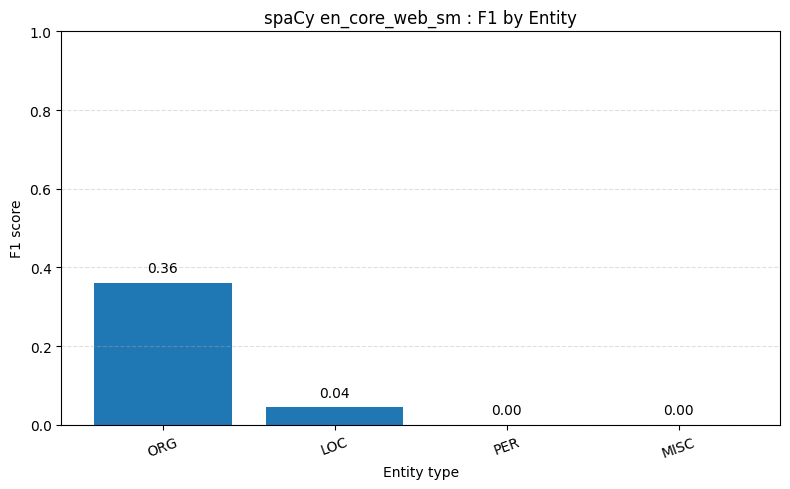

Saved plot to : plots\spacy_sm_f1_by_label.jpg


In [17]:
plot_path_sm = PLOTS_DIR / "spacy_sm_f1_by_label.jpg" 
plot_f1_bars(f1_by_label_sm, "spaCy en_core_web_sm : F1 by Entity", plot_path_sm)

## Baseline 2 : en_core_web_trf on test set

In [18]:
# Evaluating transformer model (more accurate; slower on CPU)
pred_trf, f1_trf = evaluate_model("en_core_web_trf", test_sents, test_tags)


Loading model : en_core_web_trf
Predicting....


c:\Elevvo_NLP_Internship\venv\Lib\site-packages\thinc\shims\pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):



Seqeval classification report (per entity type) :


c:\Elevvo_NLP_Internship\venv\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Elevvo_NLP_Internship\venv\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    CARDINAL      0.000     0.000     0.000         0
        DATE      0.000     0.000     0.000         0
       EVENT      0.000     0.000     0.000         0
         FAC      0.000     0.000     0.000         0
         GPE      0.000     0.000     0.000         0
    LANGUAGE      0.000     0.000     0.000         0
         LAW      0.000     0.000     0.000         0
         LOC      0.600     0.018     0.035      1668
        MISC      0.000     0.000     0.000       702
       MONEY      0.000     0.000     0.000         0
        NORP      0.000     0.000     0.000         0
     ORDINAL      0.000     0.000     0.000         0
         ORG      0.767     0.473     0.585      1661
         PER      0.000     0.000     0.000      1617
     PERCENT      0.000     0.000     0.000         0
      PERSON      0.000     0.000     0.000         0
     PRODUCT      0.000     0.000     0.000         0
    QUANTITY      0.000    

In [19]:
report_text_trf = classification_report(test_tags, pred_trf, digits=3)
f1_by_label_trf = extract_f1_per_label(report_text_trf)

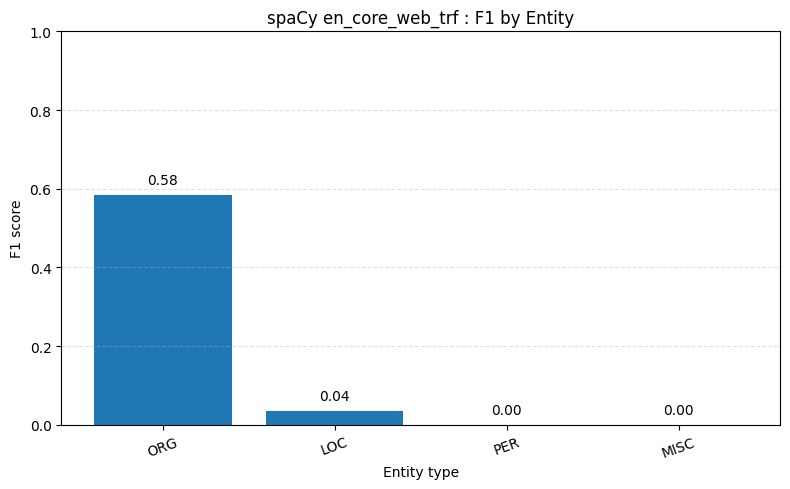

Saved plot to : plots\spacy_trf_f1_by_label.jpg


In [20]:
plot_path_trf = PLOTS_DIR / "spacy_trf_f1_by_label.jpg"
plot_f1_bars(f1_by_label_trf, "spaCy en_core_web_trf : F1 by Entity", plot_path_trf)

In [21]:
# side-by-side comparison of overall micro F1
print({
    "en_core_web_sm": round(f1_sm, 3),
    "en_core_web_trf": round(f1_trf, 3)
})

{'en_core_web_sm': 0.078, 'en_core_web_trf': 0.111}


## Rule-based booster : EntityRuler

In [22]:
def top_gazetteer(sentences, tags, label_suffix="PER", k=1000):
    words = []
    for toks, ys in zip(sentences, tags):
        for w, y in zip(toks, ys):
            if y.endswith(label_suffix) and y[0] in ("B", "I"):
                if w[:1].isupper():
                    words.append(w)
    # counting frequency
    return [w for w, _ in Counter(words).most_common(k)]

In [23]:
# Building small gazetteers from training split
top_per = top_gazetteer(train_sents, train_tags, "PER", 1500)
top_org = top_gazetteer(train_sents, train_tags, "ORG", 1500)
top_loc = top_gazetteer(train_sents, train_tags, "LOC", 1500)

len(top_per), len(top_org), len(top_loc)

(1500, 1500, 1449)

In [24]:
def make_hybrid_pipeline(base_model="en_core_web_sm", per=(), org=(), loc=()):
    nlp = spacy.load(base_model)
    # Putting ruler before 'ner' so its entities become strong hints
    ruler = nlp.add_pipe("entity_ruler", before="ner")
    patterns = []
    # PERSON in spaCy is "PERSON", not "PER"
    patterns += [{"label": "PERSON", "pattern": w} for w in per]
    patterns += [{"label": "ORG",    "pattern": w} for w in org]
    patterns += [{"label": "LOC",    "pattern": w} for w in loc]
    ruler.add_patterns(patterns)
    return nlp

In [25]:
# Building hybrid model on top of small baseline
nlp_hybrid = make_hybrid_pipeline("en_core_web_sm", per=top_per, org=top_org, loc=top_loc)

In [26]:
# Evaluating hybrid model
pred_hybrid = predict_bio(nlp_hybrid, test_sents)
print(classification_report(test_tags, pred_hybrid, digits=3))
f1_hybrid = f1_score(test_tags, pred_hybrid)
print("Hybrid (sm + ruler) F1 : ", round(f1_hybrid, 3))

c:\Elevvo_NLP_Internship\venv\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Elevvo_NLP_Internship\venv\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    CARDINAL      0.000     0.000     0.000         0
        DATE      0.000     0.000     0.000         0
       EVENT      0.000     0.000     0.000         0
         FAC      0.000     0.000     0.000         0
         GPE      0.000     0.000     0.000         0
    LANGUAGE      0.000     0.000     0.000         0
         LAW      0.000     0.000     0.000         0
         LOC      0.480     0.592     0.530      1668
        MISC      0.000     0.000     0.000       702
       MONEY      0.000     0.000     0.000         0
        NORP      0.000     0.000     0.000         0
     ORDINAL      0.000     0.000     0.000         0
         ORG      0.254     0.382     0.305      1661
         PER      0.000     0.000     0.000      1617
     PERCENT      0.000     0.000     0.000         0
      PERSON      0.000     0.000     0.000         0
     PRODUCT      0.000     0.000     0.000         0
    QUANTITY      0.000    

In [27]:
# Plotting per-entity F1 for the hybrid pipeline
report_text_hybrid = classification_report(test_tags, pred_hybrid, digits=3)
f1_by_label_hybrid = extract_f1_per_label(report_text_hybrid)

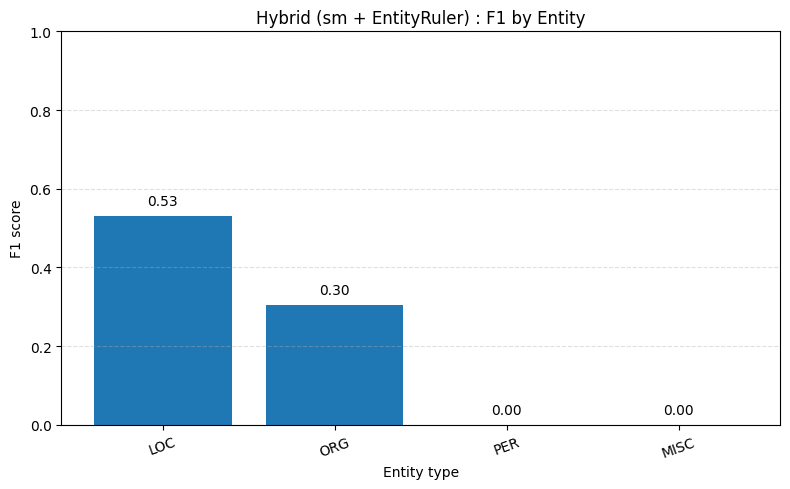

Saved plot to : plots\spacy_sm_hybrid_f1_by_label.jpg


In [28]:
plot_path_hybrid = PLOTS_DIR / "spacy_sm_hybrid_f1_by_label.jpg"
plot_f1_bars(f1_by_label_hybrid, "Hybrid (sm + EntityRuler) : F1 by Entity", plot_path_hybrid)

In [30]:
# Comparing all
summary = {
    "en_core_web_sm": round(f1_sm, 3),
    "en_core_web_trf": round(f1_trf, 3),
    "hybrid_sm_plus_ruler": round(f1_hybrid, 3),
}

summary

{'en_core_web_sm': 0.078,
 'en_core_web_trf': 0.111,
 'hybrid_sm_plus_ruler': 0.203}

## Visualizing extracted entities with displacy

In [33]:
viz_model_name = "en_core_web_trf"
nlp_viz = spacy.load(viz_model_name)
print("Visualization model : ", viz_model_name)

Visualization model :  en_core_web_trf


In [ ]:
def collect_examples(sents, k=5, max_tries=200):
    examples = []
    tries = 0
    while len(examples) < k and tries < max_tries:
        idx = random.randrange(len(sents))
        text = " ".join(sents[idx])
        doc  = nlp_viz(text)
        if len(doc.ents) > 0:        # keep only interesting ones
            examples.append(doc)
        tries += 1
    return examples

In [42]:
docs = collect_examples(test_sents, k=10)

In [43]:
viz_options = {
    "ents": ["PERSON","ORG","LOC","MISC"],  # only CoNLL types
    "fine_grained": False
}
html = displacy.render(docs, style="ent", options=viz_options, page=True, jupyter=False)

out_path = PLOTS_DIR / "displacy_examples.html"
with open(out_path, "w", encoding="utf-8") as f:
    f.write(html)

print(f"Saved displacy visualization to : {out_path}")

Saved displacy visualization to : plots\displacy_examples.html
